# Policy Evaluation and Robustness Analysis

In this notebook, the Pareto-optimal polices from the MORDM are further evaluated on robustness. This is done by: 
- computing a signal-to-noise ratio for each outcome,which balances average effectiveness with consistency
- quantifying policy regret, which measures how much worse each policy performs compared to the best possible outcome in each scenario.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from ema_workbench import (
    Policy, MultiprocessingEvaluator, save_results, load_results, ScalarOutcome)
from ema_workbench.analysis import parcoords, prim
from problem_formulation import get_model_for_problem_formulation

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


**Import the policies and model**

In [5]:
# Load Pareto-optimal policies from CSV file
pareto_policies = pd.read_csv('data/Pareto_Optimal_Results.csv')
# Load the dike model and its steps for the specified problem formulation (formulation 2)
dike_model, steps = get_model_for_problem_formulation(2)

# Creating Policies and Running Experiments

The Pareto-optimal policies are converted into EMA Workbench Policy objects with unique names. Using a MultiprocessingEvaluator, the dike model is then run for 1000 scenarios per policy, generating results that capture each policy’s performance under uncertainty.

In [6]:
policy_list = []

# Convert each row in pareto_policies DataFrame into an EMA Workbench Policy object
for i, policy in pareto_policies.iterrows():
    policy_dictionary = policy.to_dict()  # Convert policy row to dictionary
    name = f"policy_{i}"  # Create a unique policy name
    # Create Policy object with name and parameters, then add to the list
    policy_list.append(Policy(name=name, **policy_dictionary))

In [7]:
# Define the number of uncertain scenarios to simulate for each policy
n_scenarios = 1000

# Use parallel processing to efficiently run the dike model experiments
with MultiprocessingEvaluator(dike_model) as evaluator:
    # Perform experiments for all policies across the specified number of scenarios
    results = evaluator.perform_experiments(
        scenarios=n_scenarios, policies=policy_list)

100%|████████████████████████████████████| 93000/93000 [35:18<00:00, 43.90it/s]


# Computing Signal-to-Noise Ratios for Policy Outcomes

A function is made that calculates the signal-to-noise ratio (SNR) for each outcome. This balances mean performance against variability. For outcomes to be maximized, the ratio is mean divided by standard deviation; for those to minimize, it is mean multiplied by standard deviation.

Using this function, we compute SNR scores for all policies across all outcomes, creating a summary DataFrame. These scores are then visualized using parallel coordinate plots.

In [8]:
def signal_to_noise(data, direction):
    # Calculate mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)

    # Avoid division by zero by setting std to 1 if it is zero
    if std == 0:
        std = 1

    # For outcomes to maximize: use mean divided by std (higher is better)
    if direction == ScalarOutcome.MAXIMIZE:
        return mean / std
    else:
        # For outcomes to minimize: use mean multiplied by std (lower is better)
        return mean * std

In [9]:
# Unpack experiments and outcomes from results
experiments, outcomes = results

overall_scores = {}

# Loop through each unique policy to calculate signal-to-noise ratios
for i in np.unique(experiments['policy']):
    scores = {}
    # Select rows for current policy
    select_policy = experiments['policy'] == i

    # Calculate signal-to-noise ratio for each outcome of the policy
    for j in dike_model.outcomes:
        x = outcomes[j.name][select_policy]  # Outcome values for this policy
        ratio = signal_to_noise(x, j.kind)   # Compute signal-to-noise ratio
        scores[j.name] = ratio

    overall_scores[i] = scores  # Store scores per policy

# Convert the overall scores dictionary to a DataFrame for easier analysis
scores_df = pd.DataFrame.from_dict(overall_scores).T
scores_df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy_0,2.172397e+18,0.0,0.0,0.000000e+00,2.000619
policy_1,1.863578e+18,0.0,151900000.0,0.000000e+00,1.264023
policy_10,2.057846e+18,6320800.0,121200000.0,3.170265e+08,0.223527
policy_11,2.109351e+18,74176430.0,0.0,3.341887e+08,0.253899
policy_12,1.862553e+18,6320800.0,151900000.0,2.191578e+08,0.163802
...,...,...,...,...,...
policy_89,1.189304e+18,33490621.0,84600000.0,1.095276e+09,0.038090
policy_9,1.948849e+18,6320800.0,30700000.0,0.000000e+00,1.412733
policy_90,1.375737e+18,66185522.0,30700000.0,6.978412e+08,0.026585
policy_91,6.275126e+17,31358014.0,176700000.0,5.311759e+08,0.006231


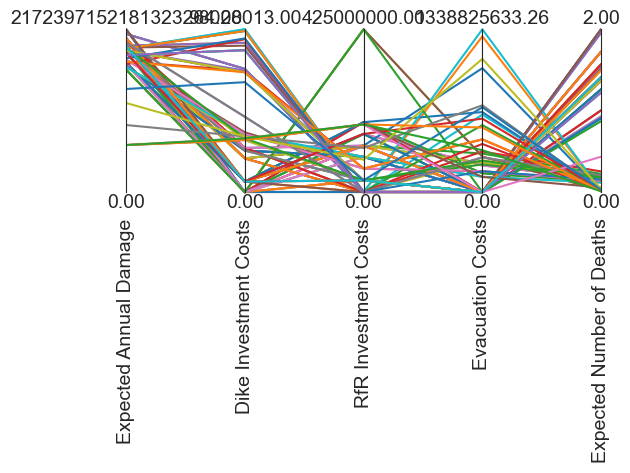

In [10]:
# Get axis limits for parallel coordinates plot based on the scores DataFrame
limits = parcoords.get_limits(scores_df)

# Set the lower bounds for selected cost and damage outcomes to zero for better visualization
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths',
               'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']] = 0

# Create parallel axes object using the calculated limits
axes = parcoords.ParallelAxes(limits)

# Plot the signal-to-noise ratio scores for all policies on parallel coordinates
axes.plot(scores_df)

# Display the plot
plt.show()

# Filtering Policies and Analyzing Regret

First 70 policies are filtered out on the highest expected number of deaths to focus on safer options. Then these results are merged into a single dataframe.

With these results the regret for each outcome by scenario and policy is computed. This is defined as the difference between the best-performing policy in that scenario and each policy's performance. 



In [11]:
# Remove the 70 policies with the highest expected number of deaths to focus on safer options
filtered_scores = scores_df.drop(
    scores_df['Expected Number of Deaths'].nlargest(70).index)

# Print the number of remaining policies after filtering
print(len(filtered_scores))

# Reset the index to convert policy names from the index into a column
filtered_policies = filtered_scores.reset_index()

# Extract the policy names as a list for further filtering or analysis
filtered_policies = filtered_policies.iloc[:, 0]
filtered_policies.tolist()

23


['policy_15',
 'policy_16',
 'policy_17',
 'policy_19',
 'policy_20',
 'policy_36',
 'policy_38',
 'policy_40',
 'policy_54',
 'policy_62',
 'policy_70',
 'policy_71',
 'policy_74',
 'policy_75',
 'policy_78',
 'policy_82',
 'policy_84',
 'policy_86',
 'policy_88',
 'policy_89',
 'policy_90',
 'policy_91',
 'policy_92']

In [12]:
# Create merged results DataFrame
results_df = pd.DataFrame(experiments).copy()
for k, v in outcomes.items():
    results_df[k] = v

# Filter for best policies
best_results = results_df[results_df['policy'].isin(filtered_policies)]

In [13]:
# Preallocate regret storage
overall_regret = {}
max_regret = {}

# Loop through each outcome
for outcome in dike_model.outcomes:
    name = outcome.name

    # Pivot data to get outcome values by [scenario, policy]
    pivot = best_results.pivot(index='scenario', columns='policy', values=name)

    # Compute regret: max value in each row (scenario) minus each policy's value
    regret_matrix = (pivot.max(axis=1).values[:, np.newaxis] - pivot).abs()

    # Store results
    overall_regret[name] = regret_matrix
    max_regret[name] = regret_matrix.max()

The maximum regret values are summarized and visualized using a heatmap to highlight outcomes and policies with the greatest potential loss.

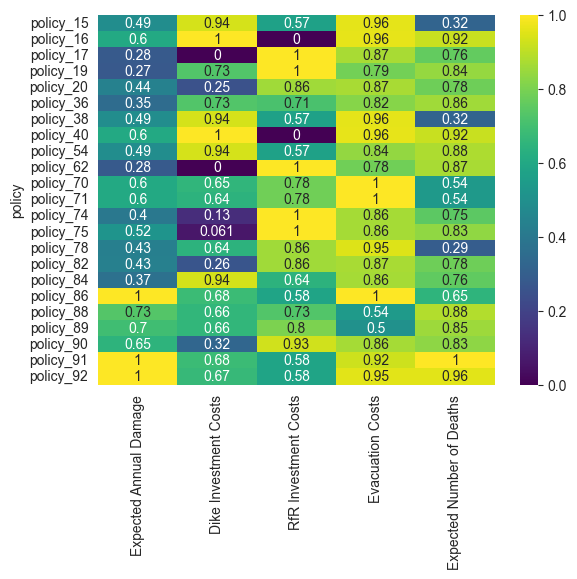

In [14]:
# Convert max_regret dictionary to a DataFrame for easier visualization
max_regret = pd.DataFrame(max_regret)

# Normalize the regret values by dividing by the maximum regret per outcome
normalized_regret = max_regret / max_regret.max()

# Plot a heatmap of normalized maximum regret values with annotations
sns.heatmap(normalized_regret, cmap='viridis', annot=True)

# Display the heatmap
plt.show()

The parallel coordinate plots display regret across selected key outcomes, allowing for multi-dimensional comparison of policy robustness.

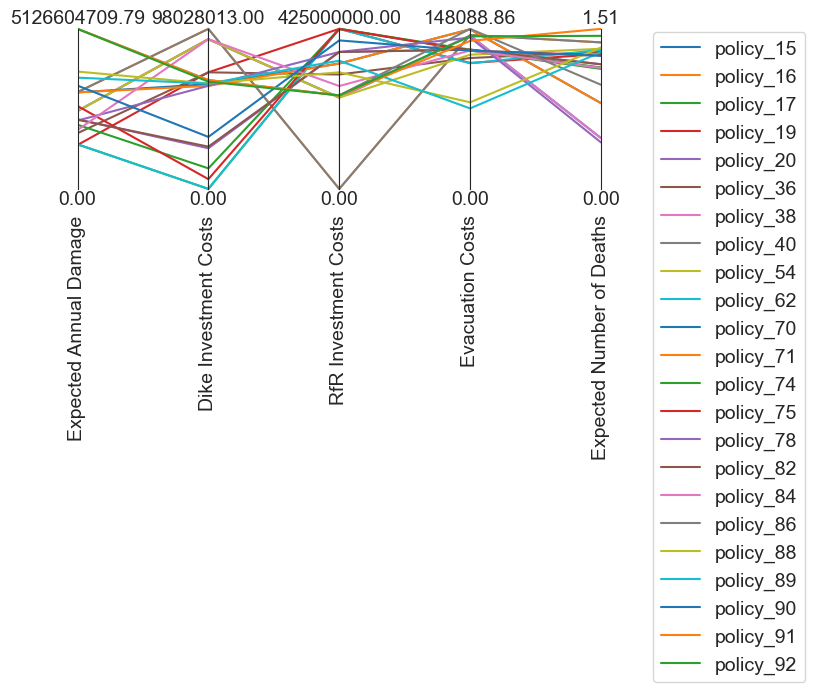

In [15]:
# Select key outcomes for detailed regret analysis
selected_outcomes = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

# Create a copy of max_regret DataFrame filtered to selected outcomes
data = max_regret[selected_outcomes].copy()

# Generate a distinct color palette with one color per policy
colors = sns.color_palette(n_colors=len(data))

# Get axis limits for parallel coordinates plot based on the data
limits = parcoords.get_limits(data)

# Set lower bounds for all selected outcomes to zero to improve plot clarity
limits.loc[0, selected_outcomes] = 0

# Initialize parallel coordinates plot with specified limits
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy’s regret profile with a unique color and label
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

# Add a legend to identify policies
paraxes.legend()

# Display the parallel coordinates plot
plt.show()

# Summarizing Policy Robustness and Visualizing Trade-offs

We calculate average investment, damages, and deaths for each policy across scenarios. These metrics are plotted to show trade-offs between cost and risk, helping identify robust policies that balance investment and impact

In [16]:
# Initialize a nested dictionary to store regret values by policy and outcome
policy_regret = defaultdict(dict)

# Loop over each outcome and its regret matrix
for key, value in overall_regret.items():
    # For each policy in the regret matrix, store its regret for the given outcome
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [17]:
# Initialize dictionary to store outcome DataFrames grouped by policy
all_policy_outcome_dfs = {}

# Group the combined results DataFrame by policy
for policy_id, group_df in results_df.groupby('policy'):
    # For each policy, store the DataFrame containing all scenario outcomes
    all_policy_outcome_dfs[policy_id] = group_df.reset_index(drop=True)

C:\Users\quint\AppData\Local\Temp\ipykernel_22432\2437666279.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for policy_id, group_df in results_df.groupby('policy'):


In [18]:
# Initialize list to store aggregated robustness metrics per policy
robustness_data = []

# Loop over each policy and its associated outcomes DataFrame
for policy_id, outcomes_df in all_policy_outcome_dfs.items():
    # Calculate total investment costs by summing different investment components
    investment = (
        outcomes_df["Dike Investment Costs"]
        + outcomes_df["RfR Investment Costs"]
        + outcomes_df["Evacuation Costs"]
    )

    # Extract damage and deaths outcomes
    damage = outcomes_df["Expected Annual Damage"]
    deaths = outcomes_df["Expected Number of Deaths"]

    # Calculate mean values of investment, damage, and deaths for the policy
    metrics = {
        "policy": policy_id,
        "investment_mean": investment.mean(),
        "damage_mean": damage.mean(),
        "deaths_mean": deaths.mean(),
    }

    # Append the metrics dictionary to the list
    robustness_data.append(metrics)

# Convert the list of dictionaries into a DataFrame for further analysis or visualization
robustness_metrics = pd.DataFrame(robustness_data)

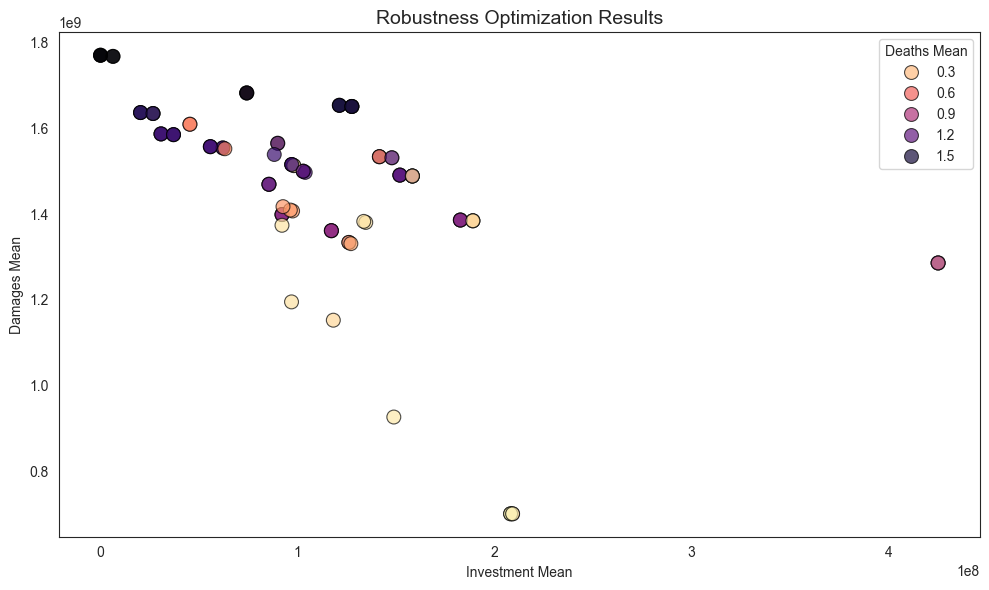

In [19]:
# Optional: rename columns for clarity if needed
df = robustness_metrics.rename(columns={
    'investment_mean': 'Investment Mean',
    'damage_mean': 'Damages Mean',
    'deaths_mean': 'Deaths Mean'
})

# Plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='Investment Mean',
    y='Damages Mean',
    hue='Deaths Mean',
    palette='magma_r',
    s=100,
    alpha=0.7,
    edgecolor='black'
)

plt.title("Robustness Optimization Results", fontsize=14)
plt.legend(title='Deaths Mean')
plt.tight_layout()
plt.show()

This code is if we have like 2 or 3 policies we want to compare

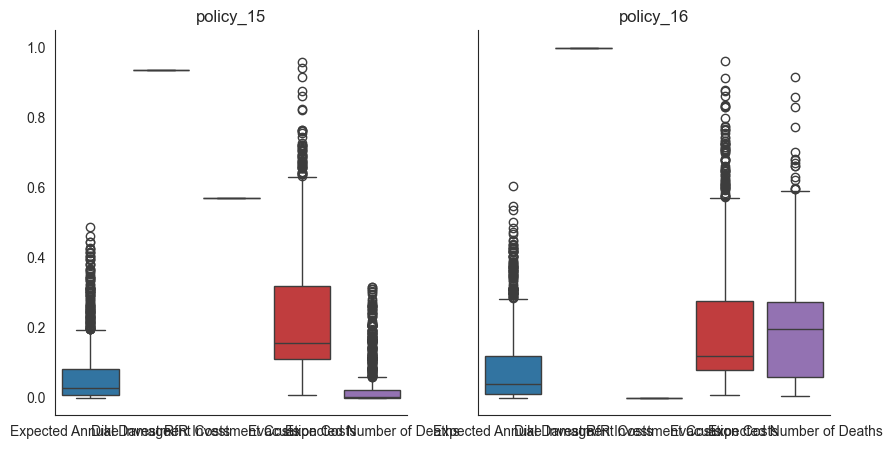

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5),
                         sharey=True, sharex=True)

for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

In [21]:
x = experiments.iloc[:, :19] # Aanpassen
y = outcomes['Expected Number of Deaths']
a = y.quantile(0.85)
Y = (y > a).astype(int).values

prim_alg = prim.Prim(x, Y, threshold=0.5)
box1 = prim_alg.find_box()

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [ ]:
box1.show_tradeoff()
plt.show()

NameError: name 'box1' is not defined

In [ ]:
box1.inspect_tradeoff()

NameError: name 'box1' is not defined

In [ ]:
#box.inspect(42)